In this notebook, we want to clarify the following question:

- for every measurement, we want to know the average temperature difference between forecasted and actual measurements
- all forecasts within the same day are clustered into one measurement
- the resulting plot should be a violin plot of 12 bars for the 12 forecast days

First, we load forecasts:

In [95]:
import pandas as pd

df_forecasts = pd.read_csv("/Users/fohlen/Downloads/export_2024-11-08/merged.csv")
df_forecasts["recorded_at"] = pd.to_datetime(df_forecasts["recorded_at"], utc=True)
df_forecasts["forecast_time"] = pd.to_datetime(df_forecasts["forecast_time"], utc=True)
df_forecasts.head()

,recorded_at,station_id,forecast_time,parameter,value
0,2024-05-12 15:00:17.390012+00:00,10513,2024-05-12 15:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
1,2024-05-12 15:00:17.390012+00:00,10513,2024-05-12 16:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
2,2024-05-12 15:00:17.390012+00:00,10513,2024-05-12 17:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
3,2024-05-12 15:00:17.390012+00:00,10513,2024-05-12 18:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
4,2024-05-12 15:00:17.390012+00:00,10513,2024-05-12 19:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0


And the actual measurements:

In [96]:
df_measure = pd.read_csv("data/historical_weather.csv")
df_measure["recorded_at"] = pd.to_datetime(df_measure["recorded_at"], utc=True)
df_measure.head()

,recorded_at,station_id,parameter,value
0,2024-05-06 00:00:00+00:00,433,precipitation_height,0.0
1,2024-05-06 01:00:00+00:00,433,precipitation_height,0.0
2,2024-05-06 02:00:00+00:00,433,precipitation_height,0.0
3,2024-05-06 03:00:00+00:00,433,precipitation_height,0.0
4,2024-05-06 04:00:00+00:00,433,precipitation_height,0.0


We also need to define a mapping between the MOSMIX region projections and the actual weather station ids, as well as the parameter mapping:

In [90]:
reverse_station_mapping = {
    433: 10384, 2667: 10513, 3379: 10865, 1443: 10803, 
    5906: 10729, 2522: 10727, 4104: 10776, 1270: 10554, 
    5419: 10555
}

reverse_parameter_mapping = {
    'precipitation_height': 'precipitation_height_significant_weather_last_1h',
    'temperature_air_mean_2m': 'temperature_air_mean_200'
}

In the next section we:

- iterate through every hour in the measurements
- filter the forecast dataframe by station id and forecasted time
- bin the measured time of the forecast by daily frequency
- calculate the distance between the forecast and measurement
- put the difference into a binned results dictionary

In [123]:
from typing import Mapping
from itertools import product
from collections import defaultdict
from tqdm.contrib.concurrent import thread_map

min_recorded = df_measure.recorded_at.min()
max_recorded = df_measure.recorded_at.max()
#min_recorded = pd.to_datetime("2024-08-01", utc=True)
#max_recorded = pd.to_datetime("2024-08-02", utc=True)

measure_times = pd.date_range(min_recorded, max_recorded, freq="1d").tolist()
station_ids = list(reverse_station_mapping.keys())
parameters = list(reverse_parameter_mapping.keys())


Difference = Mapping[int, list[int]]


def compute_differences(
    *args
) -> tuple[Difference, Difference]:
    measure_time, station_id, parameter = args[0]
    daily_difference_rain = defaultdict(list)
    daily_difference_temp = defaultdict(list)

    rows_measure = df_measure[
        (df_measure.recorded_at == measure_time) &
        (df_measure.station_id == station_id) &
        (df_measure.parameter == parameter)
    ]

    if (len(rows_measure)):
        value = rows_measure.value.iloc[0]

        forecast_rows = df_forecasts[
            (df_forecasts["forecast_time"] == measure_time) &
            (df_forecasts["station_id"] == reverse_station_mapping[station_id]) &
            (df_forecasts["parameter"] == reverse_parameter_mapping[parameter])
        ]
    
        for name, group in forecast_rows.groupby(forecast_rows.recorded_at.dt.date):
                day_diff = (measure_time - group.recorded_at.max()).days
                
                for index, row in group.iterrows():
                        diff = abs(row["value"] - value)
                            
                        if parameter == "precipitation_height":
                            daily_difference_rain[day_diff].append(diff)
                        else:
                            daily_difference_temp[day_diff].append(diff)

    return daily_difference_rain, daily_difference_temp


def merge_diffs(differences: list[tuple[Difference, Difference]]) -> tuple[Difference, Difference]:
    daily_difference_rain = defaultdict(list)
    daily_difference_temp = defaultdict(list)

    for d1, d2 in differences:
        for key, value in d1.items():
            daily_difference_rain[key].extend(value)

        for key, value in d2.items():
            daily_difference_temp[key].extend(value)

    return daily_difference_rain, daily_difference_temp


param_grid = list(product(measure_times, station_ids, parameters))

diffs = thread_map(compute_differences, param_grid)
merged_diffs = merge_diffs(diffs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3330/3330 [43:42<00:00,  1.27it/s]


After calculating the flat differences, we should create a dataframe:

In [124]:
dfs_rain = [
    pd.DataFrame({day: pd.Series(values)}) 
    for day, values in merged_diffs[0].items()
]

df_rain = pd.concat(dfs_rain, axis=1) 

dfs_sun = [
    pd.DataFrame({day: pd.Series(values)}) 
    for day, values in merged_diffs[1].items()
]

df_sun = pd.concat(dfs_sun, axis=1) 

And finally visualize it in a violin plot

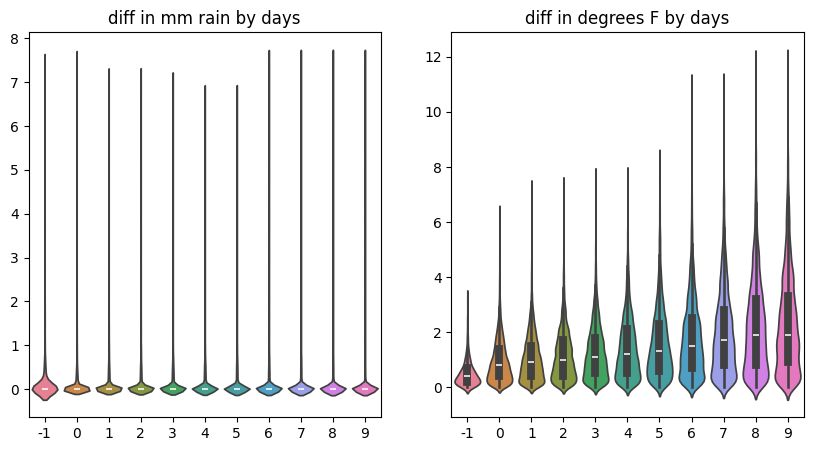

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(df_rain, ax=axs[0])
axs[0].set_title("diff in mm rain by days")
sns.violinplot(df_sun, ax=axs[1])
axs[1].set_title("diff in degrees F by days") 

plt.show()